## The Variational Quantum Thermalizer Algorithm

In [2]:
#Importing the necessary dependencies

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize
import math
import scipy
from matplotlib import pyplot as plt

**Table of Contents**

1. Introduction
2. The Variational Quantum Thermalizer
3. A Sanity Check: Numerical Simulation of the VQT
4. A Small Tangent: Constructing the RYY Gate
5. VQT At Zero Temperature: The Variational Quantum Eigensolver
6. The Real Thing: VQT With Sampling
7. Conclusion and References

**Introduction**

The goal of this Notebook will be to help the reader understand a very interesting, recently-proposed NISQ algorithm called the **Variational Quantum Thermalizer**. This paper was one of many that has been written by the quantum team at X, the Moonshot Factory in the past couple years. Essentially, this algorithm is able to use a variational approach to reconstruct the thermal state of a given Hamiltonian at a given temperature, which is a task that is performed much more efficiently on a quantum device than a classical simulation performing the same calculations (in a very similar respect to the Variational Quantum Eigensolver). In fact, as in the original paper, we will demonstrate in this Notebook that as temperature approaches $0$, this algorithm is completely equivalent to the VQE, making the VQT a natural generalization of VQE!

**The Variational Quantum Thermalizer: The Problem Statement**

Before we actually jump into simulations of this algorithm, we will attempt to understand the mathematical and physical theory that makes this theory possible. I'm going to assume that the reader already understands why variational processes like VQE and QAOA work from a physical perspective (this knowledge isn't absolutely necessary, but it is helpful, and it just so happens that a comprehensive explanation can be found in my CV QAOA Notebook!)

First off all, let us consider what we are actually trying to accomplish using this algorithm. We want to construct a **thermal state**, which is defined as:

<br><br>
$$\rho_\text{thermal} \ = \ \frac{e^{- H \beta / k_B}}{\text{Tr}(e^{- H \beta / k_B})}$$
<br><br>

Where $H$ is the Hamiltonian of our system, $\beta \ = \ 1/T$, where $T$ is the temperature of our system, and $k_B$ is Boltzman's constant (we will set this to $1$, for simplicity). Inputted into our algorithm is this Hamiltonian $H$, and our goal is to find $\rho_\text{thermal}$, or more specifically, the variational parameters that give us a state that is "very close" to $\rho_\text{thermal}$, as one does in any kind of variational quantum algorithm.

In order to do this, we will essentially pick some "simple" mixed state to start our process. We will then sample from the probability distribution of measurements of different pure states. More concretely, if we have some mixer state:

<br><br>
$$\rho \ = \ \displaystyle\sum_{i} p_i |x_i\rangle \langle x_i|$$
<br><br>

Then our probability distribution is defined as $x_i \ \sim \ p_i$, where $x_i$ corresponds to $|x_i\rangle$. We repeatedly sample values of $x_i$ corresponding to pure states in the expansion of our "simple" mixed state and pass them through a parametrized quantum circuit. We repeat this process, calculating the expectation value of the Hamiltonian for our transformed mixed state and use this value along with the Von Neumann entropy of our state to create a **free energy cost function**. We repeat the algorithm with new parameters until we minimize free energy. Once we have done this, we have arrived at the thermal state! The entire process look somewhat like this (this beautiful illustration was taken from the original paper):

<br>
<img src="assets/vqt.png" style="height:250px">
<br>

The dark grey boxes show the variational parameters that we feed into the algorithm, $\theta$ determines the probability distribution and $\phi$ determines the nature of the unitary ansatz circuit. The light grey boxes represent classical subroutines (we can sample from our probability distribution, calculate the Von Neumann entropy, $S_{\theta}$, and calculate the expectation value of our Hamiltonian classicaly). To prepare the pure state $|x\rangle$ that we samples from the distribution, we have to use the quantum subroutine $\hat{V}_x$, and then we "evolve" our basic quantum state with the variational ansatz $\hat{U}(\phi)$. Finally, we calculate loss (the black box), and cycle back to the beginning of the circuit after receiving updated variational parameters from our classical optimizer.

**Constructing the Variational Quantum Thermalizer**

Now, that we understand what we are actually making, let's understand how the paper goes about constructing the VQT. We said earlier we will begin the process by creating a simple mixed state. Now, let's actually understand how we will create this simple state. Basically, the idea is to pick some $\rho_\theta$ parametrized by $\theta$ such that:

<br><br>
$$\rho_\theta \ = \ \frac{1}{Z_\theta} e^{- K_\theta}$$
<br><br>

Where $Z_\theta$ is simply the partition function that normalizes our density matrix, $Z_{\theta} \ = \ \text{Tr}(e^{- K_\theta})$. $K_\theta$ is just some simple Hamiltonian. 

Our motivation for constructing our simple mixed state in this fashion is that it is similar in structure to that of the thermal state, which is the exponential of a Hamiltonian. In addition, recall that time evolution of a density matrix is given by multiplying it left and right by the unitary that is "doing the evolving". if you're not familiar with this, since we know that evolution of the form $|\psi\rangle \ \rightarrow \ |\psi'\rangle$ is given by $|\psi'\rangle \ = \ U|\psi\rangle$, we know that some density matrix will evolve as:

<br><br>
$$\rho \ = \ \displaystyle\sum_{i} p_i |\psi_i\rangle \langle \psi_i | \ \rightarrow \ \displaystyle\sum_{i} p_i |\psi_i'\rangle \langle \psi_i' | \ = \ \displaystyle\sum_{i} p_i U |\psi_i\rangle \langle \psi_i | U^{\dagger} \ = \ U \rho U^{\dagger}$$
<br><br>

Anyways, getting back to $K_{\theta}$, we must consider a method for selecting it. Luckily, the paper gives us a fairly obvious choice for this Hamiltonian:

<br><br>
$$K_{\theta} \ = \ \displaystyle\sum_{x} \theta_x |x\rangle \langle x|$$
<br><br>

Where each $|x\rangle$ is a computational basis state of our qubit system. This Hamiltonian is quite simple, it is diagonal in the basis that we are used to operating in, and all we have to do is take our variational parameters and slap them onto the outer products of the different basis states. We can then construct our initial mixed state as follows:

<br><br>
$$\rho_{\theta} \ = \ \frac{1}{Z_{\theta}} e^{-K_{\theta}} \ = \ \frac{1}{Z_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-K_{\theta})^n}{n!} \ = \ = \ \frac{1}{Z_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-\sum_{k} \theta_k |k\rangle \langle k|)^n}{n!} \ = \ \frac{1}{Z_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \displaystyle\sum_{k} \ \frac{(-\theta_k)^n}{n!} |k\rangle \langle k| \ = \ \frac{1}{Z_{\theta}} \displaystyle\sum_{k} e^{-\theta_k} |k\rangle \langle k |$$
<br><br>

This is great! All we have to do is sample from the probability distribution of $k \ \sim \ \frac{1}{Z_\theta} e^{-\theta_k}$, prepare $|k\rangle$ which is fairly easy, since it is just a computational basis state, pass it through $\hat{U}(\phi)$, which we will dsicuss soon, and then repeat this process to calculate the expectation value and the cost function. 

Let's talk more about the cost function. We will define our cost function to be the following, which we call the **free energy** of our system:

<br><br>
$$\mathcal{L}(\theta, \ \phi) \ = \ \beta \langle \hat{H} \rangle \ - \ S_\theta \ = \ \beta \ \text{Tr} (\hat{H} \ \rho_{\theta \phi}) \ - \ S_\theta \ = \ \beta \ \text{Tr}( \hat{H} \ \hat{U}(\phi) \rho_{\theta} \hat{U}(\phi)^{\dagger} ) \ - \ S_\theta$$
<br><br>

This cost function has a couple components, the first of which is the expectation value of our Hamiltonian with respect to our variationally-prepared density matrix. 

**TODO**

- Add in more about cost function, Von Neumann Entropy, explanation as to why thermal states minimize the cost function
- Talk about how Von Neumann entropy is invariant under unitary transformations

- Then, talk about the parametrization of the latent space: Factorized

- Finally, talk about constructing $\hat{U}(\phi)$

**A Sanity Check: Numerical Simulation of the VQT**

Now that we havegone through a lot of the necessary mathematical rigour to understand how VQT works, we can now attempt to simulate it! Before we attempt to simulate VQT as it was designed to be run on a real quantum computer, we're going to first create a numerical simulation to ensure that we actually know what we're doing, then we'll modify some of the code to create a sampling-based simulation.

**A Small Tangent: Constructing the RYY Gate**

In order to implement the state-preparation ansatz circuit outlined in the original paper, one of the necessary gates that must be applied to our qubit register is the exponential $Y \ \otimes \ Y$ coupling gate. Qiskit only supports the $RZZ$ and the $RXX$ gates, so it is necessary to decompose our $RYY$ gate into a product of these gates. This is fairly simple. We define the exponential $YY$ gate as:

<br><br>
$$RYY(\theta) \ = \ \exp \Big( -i\theta (Y \ \otimes \ Y) \Big)$$
<br><br>

We assert that: $RYY(\theta) \ = \ (S \ \otimes \ S) \ RXX(\theta) \ (S^{\dagger} \ \otimes S^{\dagger})$, where $S$ is the phase gate. This is easy to prove:

<br><br>
$$(S \ \otimes \ S) \ RXX(\theta) \ (S^{\dagger} \ \otimes S^{\dagger}) \ = \ (S \ \otimes S) \ \exp \Big( -i\theta (X \ \otimes \ X) \Big) \ (S^{\dagger} \ \otimes S^{\dagger}) \ = \ \exp \Big( -i\theta (S X S^{\dagger} \ \otimes \ S X S^{\dagger}) \Big)$$
<br>
$$\Rightarrow \ \exp \Big( -i\theta (S X S^{\dagger} \ \otimes \ S X S^{\dagger}) \Big) \ = \ \exp \Big( -i\theta (Y \ \otimes \ Y) \Big) \ = \ RYY(\theta)$$
<br><br>

We are allowed to bring our $S$ and $S^\dagger$ operations into the exponential due to unitary exponentiation:

<br><br>
$$U \exp (A) U^{\dagger} \ = \ U \Big( \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{(A \ \mathbb{I})^n}{n!} \Big) U^{\dagger} \ = \ \Big( \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{U (A \ U^\dagger U)^n U^\dagger}{n!} \Big) \ = \ \Big( \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{(UAU^\dagger)^n}{n!} \Big) \ = \ \exp (U A U^\dagger)$$
<br><br>

We can code this up in Qiskit with relative ease!

In [11]:
#Creates the RYY gate using the RXX gate and single-qubit rotations

def ryy_gate(circ, qubit1, qubit2, theta):

    circ.s(qubit1)
    circ.s(qubit2)
    circ.rxx(theta, qubit1, qubit2)
    circ.sdg(qubit1)
    circ.sdg(qubit2)

**CODE TO BE USED IN NOTEBOOK**

In [12]:
# Sets the values of the initial parameters

beta = 0.1 #Note that B = 1/T
trotter = 1
qubit = 3
depth = 1
runs = 20
dimension = qubit


double_pair = [[[0, 1], [1, 2]]]
single_pair = [[0, 1, 2]]

In [13]:
#Creates the double rotational ansatz outlined in the paper (modified slightly for the 1D Heisenberg model)

def double_rotation(circ, trot_depth, phi_params, qubit1, qubit2):
        
    circ.rzz(phi_params[0], qubit1, qubit2)
    circ.rxx(phi_params[1], qubit1, qubit2)
    ryy_gate(circ, qubit1, qubit2, phi_params[2])

# Creates the single rotational ansatz outlined in the paper (modified slightly for the 1D Heisenberg model)

def single_rotation(circ, trot_depth, phi_params, qubit):

    circ.rz(phi_params[0], qubit)
    circ.ry(phi_params[1], qubit)
    circ.rx(phi_params[2], qubit)

# Creates the U gate unitary to apply to the initial qubit state
def add_u_gate(circ, double_phi, single_phi, qubit):
    for j in range(0, depth):
        for i in range(0, qubit-1):
            double_rotation(circ, trotter, double_phi[j][i], double_pair[j][i][0], double_pair[j][i][1])
        for i in range(0, qubit):
            single_rotation(circ, trotter, single_phi[j][i], i)
        for i in range(0, qubit-1):
            double_rotation(circ, trotter, double_phi[j][i], double_pair[j][i][0], double_pair[j][i][1])

In [14]:
#Creates the initialization unitary for each of the computational basis states

def create_v_gate(circ, prep_state):

    for i in range(0, len(prep_state)):
        if (prep_state[i] == 1):
            circ.x(i)

In [15]:
# Creates the probability distribution according to the theta parameters
def create_dist(theta_param):

    prob = []
    for i in range(0, len(theta_param)):
        prob.append([math.exp(-1*theta_param[i]), 1-math.exp(-1*theta_param[i])])

    return prob

    # REMEBER TO RESTRICT THETA TO POSITIVE VALUES

In [16]:
#Prepares the Hamiltonian matrix for the n-qubit 1D Heisenberg model

def create_hamiltonian_matrix(n):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])
    
    matrix = np.zeros((2**n, 2**n))

    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_y)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    return matrix

print(create_hamiltonian_matrix(3))

[[ 2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -2.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j -2.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j]]


In [17]:
def run_circuit(qubit, theta, double_phi, single_phi):
    
    circ = QuantumCircuit(qubit, qubit)

    prob = create_dist(theta)

    # Sample values for each of the qubits
    samples = []
    for dist in prob:
        sample = list(np.random.choice(2, 1, p=[dist[0], dist[1]]))[0]
        samples.append(sample)

    #Prepares the initial state corresponding to the sampled values
    create_v_gate(circ, samples)

    #Apply the unitary to this combination of basis states
    add_u_gate(circ, double_phi, single_phi, qubit)

    
    #Compute the expectation value of the Hamiltonian
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ)
    
    ham_matrix = create_hamiltonian_matrix(qubit)
    
    e_val = np.inner(np.conj(outputstate), np.matmul(ham_matrix, outputstate)).real

    return [e_val, samples]

In [18]:
# SAMPLING COST FUNCTION

def cost_function(param):
    
    ham_matrix = create_hamiltonian_matrix(qubit)
    
    double_phi = [[param[0:3], param[3:6]]]
    single_phi = [[param[6:9], param[9:12], param[12:15]]]
    theta = param[15:18]

    opt_prob_dist = create_dist(theta)

    p = []
    for i in range(0, 2):
        for j in range(0, 2):
            for v in range(0, 2):
                p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

    state = np.zeros((2**dimension, 2**dimension))
    
    for l in range(0, 2**dimension):

        circ = QuantumCircuit(dimension)

        create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(dimension))])
        add_u_gate(circ, double_phi, single_phi, qubit)
        

        backend = Aer.get_backend('statevector_simulator')
        job = execute(circ, backend)
        result = job.result()
        outputstate = result.get_statevector(circ)
        
        state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))
    
    entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))
    
    
    print("Entropy: "+str(entropy))
    print("EV: "+str(np.trace(np.matmul(ham_matrix, state))))
    
    cost = beta*np.trace(np.matmul(ham_matrix, state)) - entropy
    print(cost.real)
    return cost.real

In [19]:
# NUMERICAL COST FUNCTION

def cost_function(param):

    # Creates different phi and theta param lists

    double_phi = [[param[0:3], param[3:6]]]
    single_phi = [[param[6:9], param[9:12], param[12:15]]]
    theta = param[15:18]

    # Repeatedly calculate the expectation value of our Hamiltonian for different sampled |x>

    ev = 0
    entropy = [[0 for j in range(0, 2)] for i in range(0, qubit)]

    for i in range(0, runs):
        res = run_circuit(qubit, theta, double_phi, single_phi)
        ev += res[0]
        for k in range(0, len(res[1])):

            # Tracks the number of samples corresponding to the different basis states

            if (res[1][k] == 0):
                entropy[k][0] += 1
            if (res[1][k] == 1):
                entropy[k][1] += 1

    final_entropy = 0
    for i in range(0, len(entropy)):
        if (entropy[i][0] != 0):
            final_entropy -= (entropy[i][0]/runs) * np.log(entropy[i][0]/runs)
        if (entropy[i][1] != 0):
            final_entropy -= (entropy[i][1]/runs) * np.log(entropy[i][1]/runs)
    
    cost = beta*float(ev/runs) - final_entropy
    
    print("Cost Function: "+str(cost))
    
    return cost

In [20]:
#Creates lits of random numbers as the initial parameters fed into the circuit
init1 = [random.randint(100, 200)/100 for i in range(0, qubit)]
init2 = [random.randint(-100, 100)/50 for i in range(0, 5*(qubit))]
init = init2+init1

#Uses the SLSQP algorithm to minimize the cost function
#print("X0: "+str(init))

out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':250})
g = out['x']
print(out)

param = g

double_phi = [[param[0:3], param[3:6]]]
single_phi = [[param[6:9], param[9:12], param[12:15]]]
theta = param[15:18]

opt_prob_dist = create_dist(theta)

p = []
for i in range(0, 2):
    for j in range(0, 2):
        for v in range(0, 2):
            p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])
                              
state = np.zeros((2**dimension, 2**dimension))

for l in range(0, 2**dimension):
    
    circ = QuantumCircuit(dimension, dimension)
    create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(dimension))])
    add_u_gate(circ, double_phi, single_phi, qubit)
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ)
    
    state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))
    print(p[l]*np.outer(outputstate, np.conj(outputstate)))
    
ham_matrix = create_hamiltonian_matrix(qubit)
entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))
ev = np.trace(np.matmul(ham_matrix, state))

print(entropy)
print(ev)

#Creates the grid visualization of the density matrices

def create_density_plot(data, re):

    array = np.array(data)
    plt.matshow(array)
    plt.colorbar()
    if (re == 1):
        plt.title("Learned State")
    if (re == 2):
        plt.title("Target State")
    plt.show()

create_density_plot(state.real, 1)

Cost Function: -1.4534148137698026
Cost Function: -1.783260977859747
Cost Function: -1.6467276320210926


KeyboardInterrupt: 

[[ 0.81873075+0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  1.0215477 +0.j -0.22436465+0.j  0.        +0.j
   0.0215477 +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.22436465+0.j  1.26746005+0.j  0.        +0.j
  -0.22436465+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.0215477 +0.j
   0.        +0.j -0.22436465+0.j  0.0215477 +0.j  0.        +0.j]
 [ 0.        +0.j  0.0215477 +0.j -0.22436465+0.j  0.        +0.j
   1.0215477 +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.22436465+0.j
   0.        +0.j  1.26746005+0.j -0.22436465+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.0215477 +0.j
   0.        +0.j -0.22436465+0.j  1.0215477 +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   

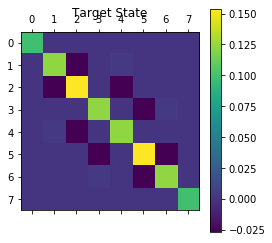

Expectation Value: (-0.6520196579683148+0j)
(-2.1112517405853586+0j)


In [21]:
h = create_hamiltonian_matrix(dimension)
ya = -1*float(beta)*h
new_matrix = scipy.linalg.expm(np.array(ya))
print(new_matrix)
norm = np.trace(new_matrix)
final_target = (1/norm)*new_matrix

print(final_target)

entropy = -1*np.trace(np.matmul(final_target, scipy.linalg.logm(final_target)))

print("Entropy: "+str(entropy))

def create_density_plot(data, re):

    array = np.array(data)
    plt.matshow(array)
    plt.colorbar()
    if (re == 1):
        plt.title("Learned State")
    if (re == 2):
        plt.title("Target State")
    plt.show()

create_density_plot(final_target.real, 2)

print("Expectation Value: "+str(np.trace(np.matmul(final_target, h))))

real_cost = beta*np.trace(np.matmul(final_target, h)) - entropy
print(real_cost)